# Definition of parameters
    Hidden states: 
    Observed states:
    Transition probabilities:
    Emmission probabilities:
    Initial distribution(stationary distribution):
    

 <h5> Possible transitions </h5> 
 
<li> $ Fair \rightarrow Fair $: $1 -0.05 =.95$ </li>
<li> $Fair \rightarrow Biased$: $0.05 $</li>
<li> $Biased \rightarrow Biased $: $1-0.10=0.90$ </li>
<li> $Biased\rightarrow Biased $: $0.10$ </li>  

The fair die is equally likely to produce observations $O=\{$1,2,3,4,5,6$\}$,   with probabilities: $Pr(i) = \frac{1}{2}$
<div>For the biased die $Pr(6)=0.5$ and $Pr(1)=Pr(2)=Pr(3)=Pr(4)=Pr(5)=0.1$</div>

In [3]:
# Import of libraries
import numpy as np 
import matplotlib.pyplot as plt
import random

In [43]:
# Reading of files 
P = np.loadtxt('/Users/adewaleadebayo/Documents/Complex computation programming/HMM/data/trans_mat.txt'
               ,usecols=(range(1,3)), skiprows=1 )
E = np.loadtxt('/Users/adewaleadebayo/Documents/Complex computation programming/HMM/data/Emis_mat.txt',
               usecols=(range(1,7)) ,skiprows=1)
pi = np.loadtxt('/Users/adewaleadebayo/Documents/Complex computation programming/HMM/data/init_dist.txt',skiprows=1)

obs_seq = np.loadtxt('/Users/adewaleadebayo/Documents/Complex computation programming/HMM/obs_sequence_D.txt',dtype=np.int32) 
# Observation sequence from Biological sequence analysis Durbin 

hid_seq = np.loadtxt('/Users/adewaleadebayo/Downloads/hid_sequence.txt', dtype=np.int32) 
# hidden sequence from Biological sequence analysis Durbin

In [30]:
# Initialise the model parameters based on the unfair casino example
states = ['Fair', 'Unfair']
states1 =['F','L']
observations = [1,2,3,4,5,6]
L=num_simulations = 300

P = np.asarray([[0.95, 0.05],  # Transition matrix between the hidden states
             [0.10, 0.90]])

E = np.asarray([[1./6 for i in range(6)],    # Emission matrix of observations of each state 
               [0.1, 0.1, 0.1, 0.1, 0.1, 0.5]])

pi = np.asarray([2./3, 1./3])  # We are using the stationary distribution as 
                               # the initial distribution for the markov chain
                                

Now based on these parameters we need to produce a sequence of **observed**  and **hidden** states using the Fitness proportion algorithm 

In [31]:
def select_state(weights):
    
    """ Determines next state of Markov Chain
    
    Returns to next state by using the fitness proportion algoritm with the initial distribution as weights
    """
    value = sum(weights) * np.random.random()
    for i,w in enumerate(weights):
        value -= w
        if value < 0 :
            return i 

In [32]:
# Check if selection algorithm works fine 
count = 0
for i in range(L):
    count += select_state(pi)
    
print ("Expected number of Fair states:",L-count)
print ("Expected number of Biased states:",count)


Expected number of Fair states: 195
Expected number of Biased states: 105


In [33]:
# simulation of Markov chain Path
def generate_hidden_seq(pi,P,L):
    """Generate sequence of hidden states of size L
    P: Transition matrix
    pi: Initial distribution 
    
    """
    hid_states = [None] * L
    #At time t=0, we use the initial distribution
    hid_states[0] = select_state(pi)
    for i in range(1,L):
        hid_states[i] = select_state(P[hid_states[i-1]])
    return hid_states


def generate_observations(hid_seq, E):
    """ Generate sequence of observations of size L
    
    Parameters
    ----------
    E: Emission matrix
    Hid_seq: Sequence of hidden Markov states
    """
    L = len(hid_seq)
    obs = [None] *L
    
    for i in range(L):
        obs[i] = select_state(E[hid_seq[i]])
        
    return obs    

In [34]:
hid_seq1 = np.asarray(generate_hidden_seq(pi,P,L))
obs_seq1 = np.asarray(generate_observations(hid_seq1, E))
#x = obs_seq

In [35]:
obs=  np.array([observations[i] for i in obs_seq1])
hidden_states = np.array([states[i] for i in hid_seq1])
np.savetxt('path.txt', hidden_states, fmt='%s', delimiter='\t')
np.savetxt('obs_sequence.txt', obs,fmt= '%f', delimiter='\t')

In [36]:
class modelHMM:
    
    """
    Order 1 Hidden Markov Model        
    Attributes
    ----------
    P : numpy.ndarray
        State transition probability matrix
    E : numpy.ndarray
        Output emission probability matrix with shape(N, number of output types)
    pi: numpy.ndarray
        Initial state probablity distribution (vector)
    L : int
        Length of sequence
        
    Common Variables
    ----------------
    obs_seq : list of int
              list of observations (represented as ints corresponding to output
              indexes in E) in order of appearance
    T : int
        number of observations in an observation sequence        
        N : int
        number of states
    """

    def __init__(self,pi,P,E,L=None):
        
        self.P  = P
        self.E  = E
        self.pi = pi
         
        

    def forward(self,obs_seq):
        """ Returns the probability of ending up in a particular state x at time t
        given the first k observations using the forward algorithm  
        """
    
        T = len(obs_seq) # Number of time steps 
        N = self.P.shape[0]   # number of states
        f = np.zeros((T,N))  # forward variable
        f[0] = self.pi * self.E[:, obs_seq[0]]
    
        for t in range(1,T):
            f[t] = np.dot(f[t-1],self.P) * self.E[:,obs_seq[t]]
            prob = f[-1].sum()
    
        return (f, prob)

    def observaion_prob(self,obs_seq):
        """ P( entire observation sequence | P, E, pi ) """
            
        return self.forward(obs_seq)[-1].sum()
    
    
    def backward(self,obs_seq):
    
        T = len(obs_seq) # Number of time steps 
        N = self.P.shape[0]   # number of states
    
        b = np.zeros((N,T))
        b[:,-1:] =1
    
        for t in reversed(range(T-1)):
            for n in range(N):
            
                b[n,t] = np.sum(b[:,t+1] * self.P[n,:] * self.E[:, obs_seq[t+1]])
            
        prob = np.sum(self.pi * self.E[:, obs_seq[0]] * b[:,0])    
    
        return (b, prob)
    
    
    def viterbi(self,obs_seq):
        """ Returns the most probable path, with the given observation sequence
        
        -------
        v : numpy.ndarray
            v [s][t] = Maximum probability of an observation sequence ending
                       at time 't' with final state 's'
        ptr : numpy.ndarray
            Contains a pointer to the previous state at t-1 that maximizes
            v[state][t]    
        """
    
        T = len(obs_seq) # Time steps
        N = self.P.shape[0]    # number of states
        v = np.zeros((T,N)) # viterbi variable
        ptr = np.zeros ((T,N)) # initialise the best path table
    
        # Initialization  
        v[0] = self.pi * self.E[:,obs_seq[0]]
    
        # Recursion 
        for t in range(1,T):
            for i in range(N):
                #seq_probs = v[t-1] * self.P[:,i] * self.E[i, obs_seq[t]]
                v[t,i] = np.max(v[t-1] * self.P[:,i]) * self.E[i, obs_seq[t]]
                ptr[t,i] = np.argmax(v[t-1] * self.P[:,i])
            
        # Backtracking
        states_path = np.zeros(T, dtype = np.int32)
        states_path[T-1] = np.argmax(v[T-1]) # last state
    
        for t in range(T-2, -1, -1):         # states of (last-1)th to 0th time step
            states_path[t] = ptr[t+1, states_path[t+1]]
    
        return states_path
    
    
    def viterbi_log(self, obs_seq):
        """ Returns the most probable path, with the given HMM model and observation sequence
    
        Parameters
        ----------
        x : observation sequence 
        P : Transition matrix of hidden chain
        E : Emission matrix
        pi : Initial distribution of Markov chain(optional)
        """
        T = len(obs_seq) # Time steps, this is the length of our observation sequence
        N = P.shape[0]    # number of states
        v = np.zeros((T,N)) # viterbi variable (Probabilities of the most probable path)
        ptr = np.zeros ((T,N)) # initialise the best path table
    
        # Initialization  
        v[0] = np.log(self.pi) + np.log(self.E[:,obs_seq[0]])
    
    
        # Recursion 
        for t in range(1,T):
            for n in range(N):
                v[t,n] = np.max(v[t-1] + np.log(self.P[:,n])) + np.log(self.E[n, obs_seq[t]])#
            
                ptr[t,n] = np.argmax(v[t-1] + np.log(self.P[:,n]))
            
        # Backtracking
        states_path = np.zeros(T, dtype = np.int32) # 
        states_path[T-1] = np.argmax(v[T-1]) # last state
    
        for t in range(T-2, -1,-1):         # states of (last-1)th to 0th time step
            states_path[t] = ptr[t+1, states_path[t+1]]
    
        return states_path
    
    
    
    def posterior(self,obs_seq):
    
        f,pf = self.forward(obs_seq)
        b,pb = self.backward(obs_seq)
        obs_prob = self.observaion_prob(obs_seq)
    
        return (np.multiply(f,b.T)/ pf)

In [37]:
hmm=modelHMM(pi,P,E)
most_prob_path  = hmm.viterbi(obs_seq)
posterior_probs = hmm.posterior(obs_seq)
f,pf = hmm.forward(obs_seq)
b,pb = hmm.backward(obs_seq)

In [38]:
print("Forward Probability  = ", pf, '\n' "Backward Probability = ", pb)

Forward Probability  =  3.826668803701079e-225 
Backward Probability =  3.826668803701079e-225


In [44]:
print ('Observation sequence:','\n', [observations[i] for i in obs_seq],'\n')
print ('Simulated path:','\n', [states1[i] for i in hid_seq],'\n')
print ('Viterbi most likely path:','\n',[states1[i] for i in most_prob_path],'\n')

Observation sequence: 
 [3, 1, 5, 1, 1, 6, 2, 4, 6, 4, 4, 6, 6, 4, 4, 2, 4, 5, 3, 1, 1, 3, 2, 1, 6, 3, 1, 1, 6, 4, 1, 5, 2, 1, 3, 3, 6, 2, 5, 1, 4, 4, 5, 4, 3, 6, 3, 1, 6, 5, 6, 6, 2, 6, 5, 6, 6, 6, 6, 6, 6, 5, 1, 1, 6, 6, 4, 5, 3, 1, 3, 2, 6, 5, 1, 2, 4, 5, 6, 3, 6, 6, 6, 4, 6, 3, 1, 6, 3, 6, 6, 6, 3, 1, 6, 2, 3, 2, 6, 4, 5, 5, 2, 3, 6, 2, 6, 6, 6, 6, 6, 6, 2, 5, 1, 5, 1, 6, 3, 1, 2, 2, 2, 5, 5, 5, 4, 4, 1, 6, 6, 6, 5, 6, 6, 5, 6, 3, 5, 6, 4, 3, 2, 4, 3, 6, 4, 1, 3, 1, 5, 1, 3, 4, 6, 5, 1, 4, 6, 3, 5, 3, 4, 1, 1, 1, 2, 6, 4, 1, 4, 6, 2, 6, 2, 5, 3, 3, 5, 6, 3, 6, 6, 1, 6, 3, 6, 6, 6, 4, 6, 6, 2, 3, 2, 5, 3, 4, 4, 1, 3, 6, 6, 1, 6, 6, 1, 1, 6, 3, 2, 5, 2, 5, 6, 2, 4, 6, 2, 2, 5, 5, 2, 6, 5, 2, 5, 2, 2, 6, 6, 4, 3, 5, 3, 5, 3, 3, 3, 6, 2, 3, 3, 1, 2, 1, 6, 2, 5, 3, 6, 4, 4, 1, 4, 4, 3, 2, 3, 3, 5, 1, 6, 3, 2, 4, 3, 6, 3, 3, 6, 6, 5, 5, 6, 2, 4, 6, 6, 6, 6, 2, 6, 3, 2, 6, 6, 6, 6, 1, 2, 3, 5, 5, 2, 4, 5, 2, 4, 2] 

Simulated path: 
 ['F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F',

# Plots

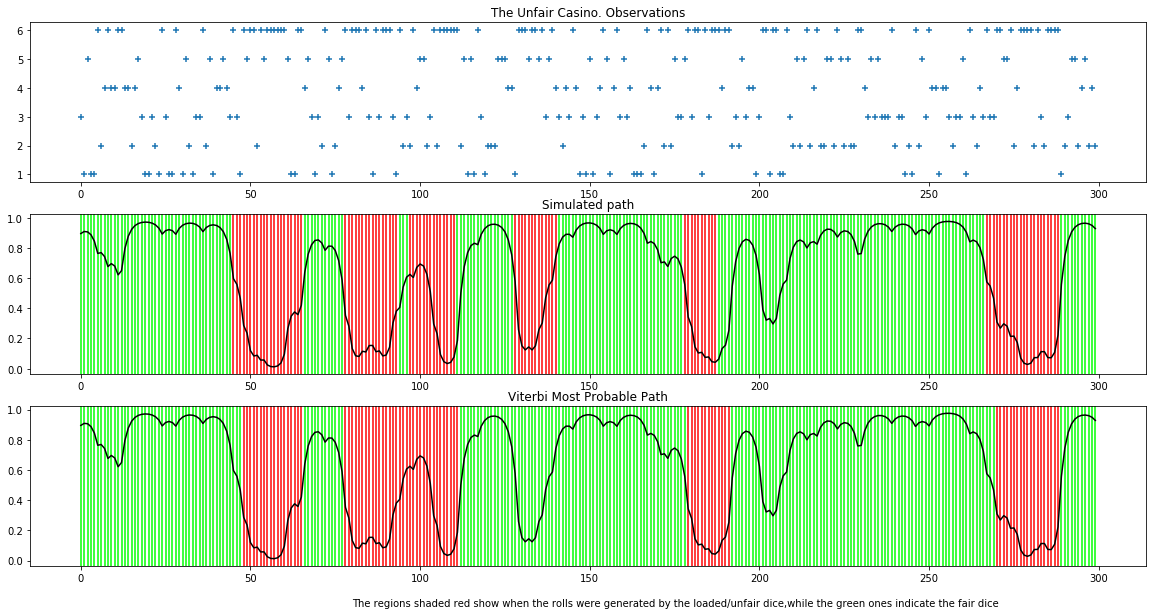

In [40]:
obs= np.array([observations[i] for i in obs_seq])
hidden_states = np.array([states[i] for i in hid_seq])
vit_states = np.array([states[i] for i in most_prob_path])

a= range(L)
fig, ax = plt.subplots(3,1, figsize=(20,10))
plt.subplot(3,1,1)
plt.scatter(a,obs,marker='+')
plt.title('The Unfair Casino. Observations')

######Simulated, which die was used (truth)####################
plt.subplot(3,1,2)
plt.title('Simulated path')
for i in range(L):
    if hidden_states[i] == 'Fair':
        plt.axvline(x = i, color ='lime' )
    else:
        plt.axvline(x = i, color = 'red')
plt.plot(a,posterior_probs[:,0],color = 'black', label= 'posteior probability')
# plt.legend()
########Most probable path (viterbi)#######################
plt.subplot(3,1,3)
plt.title('Viterbi Most Probable Path')
for i in range(L):
    if  vit_states[i] == 'Fair':
        plt.axvline(x = i, color ='lime', label='Fair')
    else:
        plt.axvline(x = i, color = 'red', label= 'Unfair')
plt.plot(a,posterior_probs[:,0],color = 'black')
plt.text(80,-0.3, 'The regions shaded red show when the rolls were generated by the loaded/unfair dice,while the green ones indicate the fair dice')
plt.savefig('sim_path.png')

##  Analysis

In [47]:
seq = []              # Contains 1000 random sequences of length L 
for i in range(1000):
    h = generate_hidden_seq(pi,P,L)    # hidden seq
    
    o = np.asarray(generate_observations(h, E)) # observation sequence
    seq.append(o)

pp = []                 # Contains the forward probabilities for each of the 1000 sequences  
for s in seq:
    p = hmm.observaion_prob(s)         # forward probability of each of the 1000 sequences 
    pp.append(p)

count1 = 0              # Number of sequences with  probabilities lower than that of the control sequence
for p in pp:
    if p < pf:
        count1 += 1
    
print ("№ of seq with probability lower than the given sequence:",count1)
print ("№ of seq with probability higher than the given sequence:",1000-count1)


№ of seq with probability lower than the given sequence: 733
№ of seq with probability higher than the given sequence: 267


In [48]:
count1/1000 * 100      # percentage of the sequence with probability lower than the control sequence 

73.3

In [ ]:
def viterbi_log(x, P, E, pi=None):
    """ Returns the most probable path, with the given HMM model and observation sequence
    
    Parameters
    ----------
    x : observation sequence 
    P : Transition matrix of hidden chain
    E : Emission matrix
    pi : Initial distribution of Markov chain(optional)
    """
    T = len(obs_seq) # Time steps, this is the length of our observation sequence
    N = P.shape[0]    # number of states
    v = np.zeros((T,N)) # viterbi variable (Probabilities of the most probable path)
    ptr = np.zeros ((T,N)) # initialise the best path table
    
# Initialization  
    v[0] = np.log(pi) + np.log(E[:,obs_seq[0]])
    
    
# Recursion 
    for t in range(1,T):
        for n in range(N):
#             v[t,n] = np.max(v[t-1] * P[:,n] * O[n, obs_seq[t]])
            v[t,n] = np.max(v[t-1] + np.log(P[:,n])) + np.log(E[n, obs_seq[t]])#
            
#             ptr[t,n] = np.argmax(v[t-1] * P[:,n]) 
            ptr[t,n] = np.argmax(v[t-1] + np.log(P[:,n]))
            
# Backtracking
    states_path = np.zeros(T, dtype = np.int32) # 
    states_path[T-1] = np.argmax(v[T-1]) # last state
    
    for t in range(T-2, -1,-1):         # states of (last-1)th to 0th time step
        states_path[t] = ptr[t+1, states_path[t+1]]
    
    return states_path

In [ ]:
most_prob_path = viterbi(x,P,E,pi)

vit_states = np.array([states[i] for i in most_prob_path])
np.savetxt('viterbi_path.txt', vit_states,fmt= '%s', delimiter='\t')

In [ ]:
def viterbi(x, P, E, pi=None):
    """ Return the most probable path, with the given HMM model and observation sequence
    
    Parameters
    ----------
    x : observation sequence 
    P : Transition matrix of hidden chain
    E : Emission matrix
    pi : Initial distribution of Markov chain(optional)
    """
    T = len(obs_seq) # Time steps
    N = P.shape[0]    # number of states
    v = np.zeros((T,N)) # viterbi variable
    ptr = np.zeros ((T,N)) # initialise the best path table
    
# Initialization  
    v[0] = pi * E[:,obs_seq[0]]
    
# Recursion 
    for t in range(1,T):
        for i in range(N):
            
            v[t,i] = np.max(v[t-1]*P[:,i]) * E[i, obs_seq[t]]
            ptr[t,i] = np.argmax(v[t-1]*P[:,i])
            
# Backtracking
    states_path = np.zeros(T, dtype = np.int32)
    states_path[T-1] = np.argmax(v[T-1]) # last state
    
    for t in range(T-2, -1,-1):         # states of (last-1)th to 0th time step
        states_path[t] = ptr[t+1, states_path[t+1]]
    
    return states_path

In [ ]:
most_prob_path = viterbi(x,P,E,pi)
vit_states = np.array([states[i] for i in most_prob_path])
np.savetxt('viterbi_path.txt', vit_states,fmt= '%s', delimiter='\t')

In [ ]:
def forward(obs_seq):
    """ Returns the probability of ending up in a particular state x at time t
    given the first k observations using the forward algorithm  
    """
    
    T = len(obs_seq) # Number of time steps 
    N = P.shape[0]   # number of states
    f = np.zeros((T,N))  # forward variable
    f[0] = pi * E[:, obs_seq[0]]
    
    for t in range(1,T):
        f[t] = f[t-1].dot(P) * E[:,obs_seq[t]]
    prob = f[-1].sum()
    
    return (f, prob)

def prob(obs_seq):
    
    return forward(obs_seq)[-1].sum()

In [ ]:
def backward(obs_seq):
    
    T = len(obs_seq) # Number of time steps 
    N = P.shape[0]   # number of states
    
    b = np.zeros((N,T))
    b[:,-1:] =1
    
    for t in reversed(range(T-1)):
        for n in range(N):
            
            b[n,t] = np.sum(b[:,t+1] * P[n,:] * E[:, obs_seq[t+1]])
            
    prob = np.sum(pi * E[:, obs_seq[0]] * b[:,0])    
    
    return (b, prob)

In [ ]:
def posterior(obs_seq):
    
    f,pf = forward(obs_seq)
    b,pb = backward(obs_seq)
    obs_prob = prob(obs_seq)
    
    return (np.multiply(f,b.T)/ obs_prob)

post_probs =posterior(obs_seq)

In [ ]:
print("Forward Probability  = ", pf, '\n' "Backward Probability = ", pb)

In [ ]:
print ('Observation sequence:','\n', [observations[i] for i in obs_seq],'\n')
print(' Simulated path:','\n', [states1[i] for i in hid_seq],'\n')
print ('Viterbi most likely path:','\n',[states1[i] for i in most_prob_path],'\n')